# Plot results from ROS bag

In [133]:
import rosbag2_py
import os
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Pose, PoseWithCovarianceStamped
from rclpy.serialization import deserialize_message
import matplotlib.pyplot as plt
from project.utils import angle_from_quaternion

print(os.getcwd())
bag_file = "/home/ubuntu/34761-Exercises/src/project/bag_files/test_with_cov5"
reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=bag_file, storage_id='sqlite3')
converter_options = rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
reader.open(storage_options, converter_options)

# Create empty lists to store the data
topics = ["/odom", "/amcl_pose", "/particle_estimation_own"]
data_keys = ["x", "y", "angle", "cov", "Timestamp"]
data_dict = {topic: {key: [] for key in data_keys} for topic in topics}

# Collect data
topics = set()
while reader.has_next():
    topic, data, timestamp = reader.read_next()
    topics.add(topic)
    if topic in data_dict.keys():
        # Deserialize the message
        msg = None
        if topic == "/odom":
            msg = deserialize_message(data, Odometry())
            data_dict[topic]["x"].append(msg.pose.pose.position.x)
            data_dict[topic]["y"].append(msg.pose.pose.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.pose.pose.orientation))
            data_dict[topic]["cov"].append(msg.pose.covariance)
        elif topic == "/amcl_pose" or topic == "/particle_estimation_own":
            msg = deserialize_message(data, PoseWithCovarianceStamped())
            data_dict[topic]["x"].append(msg.pose.pose.position.x)
            data_dict[topic]["y"].append(msg.pose.pose.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.pose.pose.orientation))
        data_dict[topic]["Timestamp"].append(msg.header.stamp.sec * 1e9 + msg.header.stamp.nanosec)
# Fix timestamps to start from 0 and from ns to seconds
latest_first_time = min([min(data_dict[key]["Timestamp"]) for key in data_dict.keys()])
for key in data_dict.keys():
    data_dict[key]["Timestamp"] = [(t - latest_first_time) / 1e9 for t in data_dict[key]["Timestamp"]]
    print(f"First timestamp for {key}: {data_dict[key]['Timestamp'][0]}")

/home/ubuntu/34761-Exercises/src/project


[INFO] [1714049391.210403291] [rosbag2_storage]: Opened database '/home/ubuntu/34761-Exercises/src/project/bag_files/test_with_cov5/test_with_cov5_0.db3' for READ_ONLY.


First timestamp for /odom: 35.92
First timestamp for /amcl_pose: 0.0
First timestamp for /particle_estimation_own: 47.88


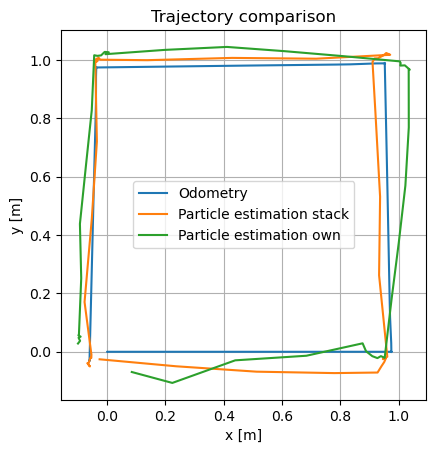

In [134]:
# Plot data
plt.figure()
plt.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], label="Odometry")
plt.plot(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], label="Particle estimation stack")
plt.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], label="Particle estimation own")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectory comparison")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
    
plt.show()

array([-2.12472280e-07, -1.95917997e-05, -2.25788779e-06, -6.13117224e-06,
        2.39097321e-01,  4.81734417e-01,  7.32552705e-01,  9.81088799e-01,
        1.23318377e+00,  1.48303632e+00,  1.59069983e+00,  1.59081980e+00,
        1.59173757e+00,  1.81653999e+00,  2.05904130e+00,  2.30967660e+00,
        2.55715687e+00,  2.80895639e+00,  3.05804273e+00, -3.12966128e+00,
       -3.13011837e+00, -3.12924708e+00, -2.89126416e+00, -2.65000203e+00,
       -2.40049007e+00, -2.15328881e+00, -1.90240010e+00, -1.65380315e+00,
       -1.59691077e+00, -1.59655360e+00, -1.59562271e+00, -1.34558371e+00,
       -1.10485172e+00, -8.56333374e-01, -6.09383305e-01, -3.59282669e-01,
       -1.11005431e-01])

In [141]:
stack_angle - odom_angle_stack

array([-0.01818717, -0.02329603, -0.02794824, -0.0328907 , -0.03383716,
       -0.02196328, -0.01824854, -0.02345977, -0.02382896, -0.01868511,
        0.00549411,  0.00810176,  0.0308428 ,  0.02720677,  0.01123908,
        0.0122866 ,  0.00732677, -0.00147704,  0.00107134,  0.00351388,
       -0.00721447, -0.00543665, -0.01686592, -0.02080723,  0.00550835,
        0.01217647,  0.01976747,  0.00838376,  0.00322495,  0.00146714,
       -0.01595554, -0.00329382, -0.0064734 , -0.0075227 , -0.00112294,
        0.00070596, -0.01173854])

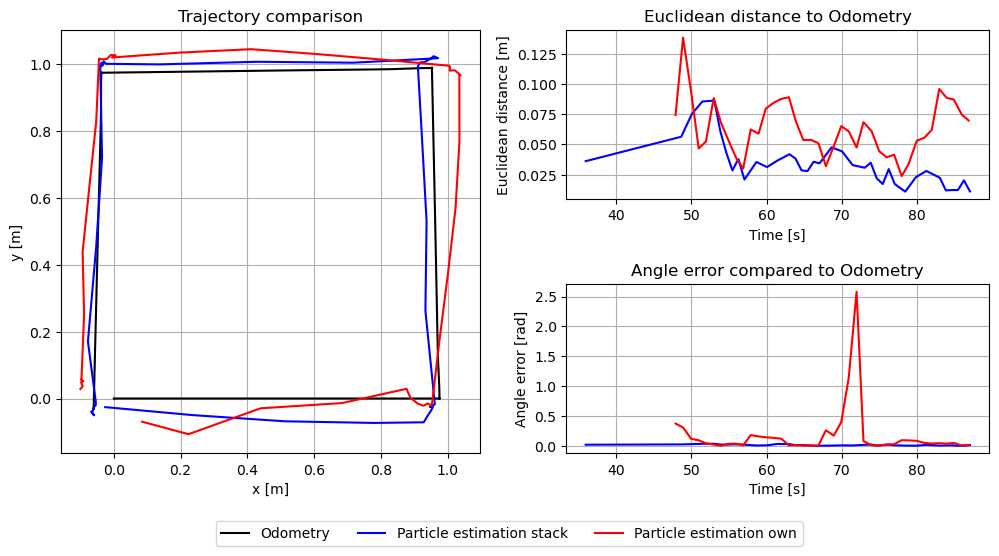

In [150]:
import numpy as np

# Plot Euclidean distance
odom_x = np.array(data_dict["/odom"]["x"])
odom_y = np.array(data_dict["/odom"]["y"])
stack_x = np.array(data_dict["/amcl_pose"]["x"])
stack_y = np.array(data_dict["/amcl_pose"]["y"])
own_x = np.array(data_dict["/particle_estimation_own"]["x"])
own_y = np.array(data_dict["/particle_estimation_own"]["y"])
odom_angle = np.array(data_dict["/odom"]["angle"])
stack_angle = np.array(data_dict["/amcl_pose"]["angle"])
own_angle = np.array(data_dict["/particle_estimation_own"]["angle"])
# Convert timestamps to numpy arrays
odom_timestamps = np.array(data_dict["/odom"]["Timestamp"])
stack_timestamps = np.array(data_dict["/amcl_pose"]["Timestamp"])
own_timestamps = np.array(data_dict["/particle_estimation_own"]["Timestamp"])

# Find the indices of the closest Odometry timestamps
stack_indices = np.searchsorted(odom_timestamps, stack_timestamps)
own_indices = np.searchsorted(odom_timestamps, own_timestamps)

# Use these indices to get the corresponding Odometry data
odom_x_stack = odom_x[stack_indices]
odom_y_stack = odom_y[stack_indices]
odom_angle_stack = odom_angle[stack_indices]
odom_x_own = odom_x[own_indices]
odom_y_own = odom_y[own_indices]
odom_angle_own = odom_angle[own_indices]

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Enable LaTeX text rendering
plt.rcParams['mathtext.fontset'] = 'cm'

# Create a gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Create subplots
fig = plt.figure(figsize=(12, 5.5))
ax1 = plt.subplot(gs[:, 0])  # Trajectory comparison plot
ax2 = plt.subplot(gs[0, 1])  # Euclidean distance plot
ax3 = plt.subplot(gs[1, 1])  # Angle error plot

# Plot trajectories
ax1.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], color='black', label="Odometry")
ax1.plot(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], color='blue', label="Particle estimation stack")
ax1.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], color='red', label="Particle estimation own")
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_title("Trajectory comparison")
ax1.grid()
ax1.set_aspect('equal', adjustable='box')

# Now use these new Odometry arrays in your distance and angle error calculations
# Now use these new Odometry arrays in your distance and angle error calculations
ax2.plot(odom_timestamps[stack_indices], np.sqrt((odom_x_stack - stack_x)**2 + (odom_y_stack - stack_y)**2), color='blue', label="Stack distance to Odometry")
ax2.plot(odom_timestamps[own_indices], np.sqrt((odom_x_own - own_x)**2 + (odom_y_own - own_y)**2), color='red', label="Own distance to Odometry")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Euclidean distance [m]")
ax2.set_title("Euclidean distance to Odometry")
ax2.grid()

# Calculate the angle error taking into account the periodic nature of angles
stack_angle_error = np.arctan2(np.sin(odom_angle_stack - stack_angle), np.cos(odom_angle_stack - stack_angle))
own_angle_error = np.arctan2(np.sin(odom_angle_own - own_angle), np.cos(odom_angle_own - own_angle))

ax3.plot(odom_timestamps[stack_indices], np.abs(stack_angle_error), color='blue', label="Stack angle error")
ax3.plot(odom_timestamps[own_indices], np.abs(own_angle_error), color='red', label="Own angle error")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Angle error [rad]")
ax3.set_title("Angle error compared to Odometry")
ax3.grid()

# Create a common legend for all plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.subplots_adjust(hspace=0.5)
plt.savefig("trajectory_comparison.pdf")
plt.show()